In [3]:
import numpy as np
import pandas as pd
import sympy as sy
import scipy.stats as si
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

df = pd.read_csv('option_data.csv')

#  Creating the target variable 'Average Price' as the average of Bid and Ask price
df['Average Price'] = (df['Bid'] + df['Ask']) / 2

# Convert date columns and calculate TimeToMaturity
df['DataDate'] = pd.to_datetime(df[' DataDate'])
df['Expiration'] = pd.to_datetime(df['Expiration'])
df['TimeToMaturity'] = (df['Expiration'] - df['DataDate']).dt.days / 252

# Drop columns not needed for modeling
columns_to_drop = [
    'Volume', 'OpenInterest', 'IVBid', 'IVAsk', 'UnderlyingSymbol',
    'Expiration', 'DataDate', 'Last', 'Delta', 'Gamma', 'Theta', 'Vega', 'OptionSymbol',
    'T1OpenInterest','AKA','Bid','Ask' 
]

# Drop unnecessary columns
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Set a constant risk-free rate
rf = 0.0187  


# Output shape 
print(f"Data Set Shape: {df.shape}")


Data Set Shape: (858, 8)


In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True) 
df.head()

,UnderlyingPrice,Type,DataDate,Strike,IVMean,Average Price,TimeToMaturity
0,174.09,call,01/05/2016,125.0,0.0874,48.875,0.011905
1,174.09,put,01/05/2016,125.0,1.9822,0.155,0.011905
2,174.09,call,01/05/2016,130.0,0.0874,43.800,0.011905
3,174.09,put,01/05/2016,130.0,1.7931,0.155,0.011905
4,174.09,call,01/05/2016,135.0,0.0874,38.925,0.011905


In [7]:
import time
import numpy as np
from scipy.stats import norm

# Defining the Black-Scholes formula
def BS_model(S, K, T, r, sigma, option):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        result = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        result = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return result

# Applying Black-Scholes formula to the test set and measuring time
start = time.time()
df['BS_Price'] = np.where(
    df['Type'] == 'call',
    BS_model(
        df['UnderlyingPrice'],
        df['Strike'],
        df['TimeToMaturity'],
        rf,
        df['IVMean'],
        option='call'
    ),
    BS_model(
        df['UnderlyingPrice'],
        df['Strike'],
        df['TimeToMaturity'],
        rf,
        df['IVMean'],
        option='put'
    )
)

# Calculating the Mean Absolute Error (MAE)
df['Absolute_error'] = np.abs(df['Average Price'] - df['BS_Price'])
end = time.time()
MAE = np.mean(df['Absolute_error'])

print(f"Black-Scholes MAE: {MAE}")
print(f"Time to compute: {end - start:.4f} seconds")

Black-Scholes MAE: 2.1818844536721405
Time to compute: 0.0110 seconds


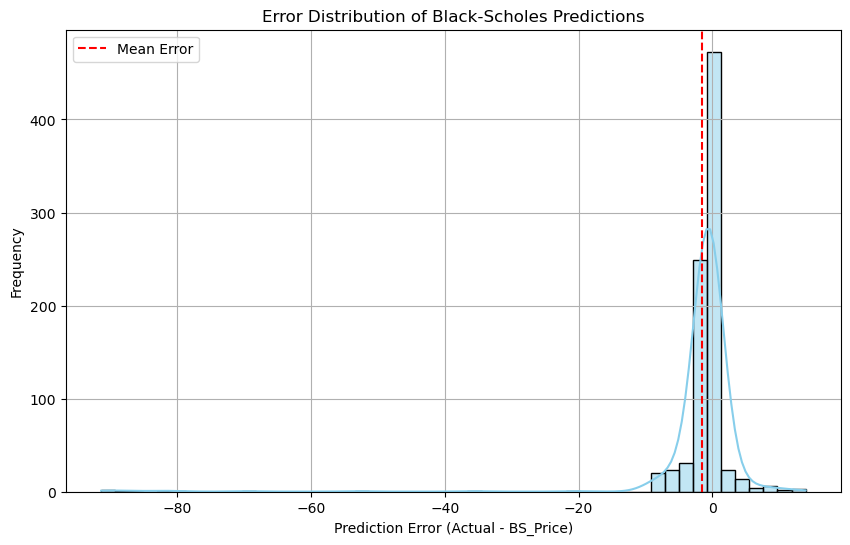

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the error
df['Error'] = df['Average Price'] - df['BS_Price']

# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Error'], kde=True,bins = 50, color='skyblue', edgecolor='black')
plt.axvline(df['Error'].mean(), color='red', linestyle='--', label='Mean Error')
plt.title('Error Distribution of Black-Scholes Predictions')
plt.xlabel('Prediction Error (Actual - BS_Price)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('plot2.png')
plt.show()


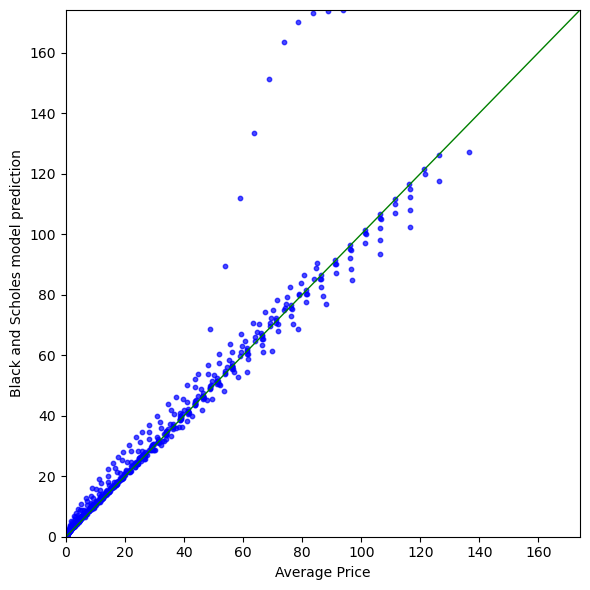

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(6, 6)) 

plt.scatter(
    df['Average Price'],
    df['BS_Price'],
    color='blue',
    alpha=0.7,
    s=10  
)

max_val = max(df['Average Price'].max(), df['BS_Price'].max())
plt.plot([0, max_val], [0, max_val], color='green', linewidth=1)
plt.xlabel('Average Price')
plt.ylabel('Black and Scholes model prediction')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.tight_layout()
plt.savefig("plot3.png") 
plt.show()


In [17]:
import numpy as np
import pandas as pd
import sympy as sy
import scipy.stats as si
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from sklearn.model_selection import train_test_split  

df = pd.read_csv('option_data.csv')

df['Average Price'] = (df['Bid'] + df['Ask']) / 2

df['DataDate'] = pd.to_datetime(df[' DataDate'])
df['Expiration'] = pd.to_datetime(df['Expiration'])
df['TimeToMaturity'] = (df['Expiration'] - df['DataDate']).dt.days / 252

columns_to_drop = [
    'Volume', 'OpenInterest', 'IVBid', 'IVAsk', 'UnderlyingSymbol',
    'Expiration', 'DataDate', 'Last', 'Delta', 'Gamma', 'Theta', 'Vega', 'OptionSymbol',
    'T1OpenInterest', 'AKA', 'Bid', 'Ask' 
]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Set a constant risk-free rate
rf = 0.0187

print(f"Data Set Shape: {df.shape}")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training Set Shape: {train_df.shape}")
print(f"Testing Set Shape: {test_df.shape}")


Data Set Shape: (858, 8)
Training Set Shape: (686, 8)
Testing Set Shape: (172, 8)


In [19]:
import time
import numpy as np
from scipy.stats import norm

# Defining the Black-Scholes formula
def BS_model(S, K, T, r, sigma, option):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes formula to the test set and measure time
start = time.time()

test_df['BS_Price'] = np.where(
    test_df['Type'] == 'call',
    BS_model(
        test_df['UnderlyingPrice'],
        test_df['Strike'],
        test_df['TimeToMaturity'],
        rf,
        test_df['IVMean'],
        option='call'
    ),
    BS_model(
        test_df['UnderlyingPrice'],
        test_df['Strike'],
        test_df['TimeToMaturity'],
        rf,
        test_df['IVMean'],
        option='put'
    )
)

# Calculate MAE on the test set
test_df['Absolute_error'] = np.abs(test_df['Average Price'] - test_df['BS_Price'])
MAE = test_df['Absolute_error'].mean()
end = time.time()

# Output results
print(f"Black-Scholes MAE on Test Set: {MAE:.4f}")
print(f"Time to compute on test set: {end - start:.4f} seconds")


Black-Scholes MAE on Test Set: 3.0840
Time to compute on test set: 0.0142 seconds


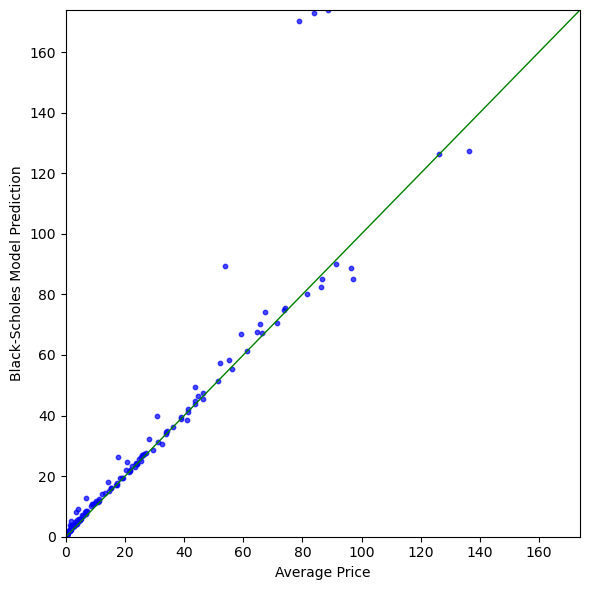

In [23]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted prices (test set only)
plt.figure(figsize=(6, 6)) 

plt.scatter(
    test_df['Average Price'],
    test_df['BS_Price'],
    color='blue',
    alpha=0.7,
    s=10  
)

max_val = max(test_df['Average Price'].max(), test_df['BS_Price'].max())
plt.plot([0, max_val], [0, max_val], color='green', linewidth=1)
plt.xlabel('Average Price')
plt.ylabel('Black-Scholes Model Prediction')
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.tight_layout()
plt.savefig("plot4.png") 
plt.show()
